# **Mini Project 1**

0. Requirements:
   
   If you do not have the following packages installed, run the command below to install them.

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install codecarbon
!pip install shap
!pip install pyprind

1. Data Preparation:
   
    Goal: Load and inspect the IMDb dataset containing movie reviews labeled with positive and negative sentiments.(https://ai.stanford.edu/%7Eamaas/data/sentiment/)
    
    Task: Read the dataset, store the reviews and their associated sentiments, and explore the dataset to understand its structure.

In [3]:
import os
import pandas as pd
import numpy as np
import re
import shap
import pyprind
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker

# TASK 1: Data Preparation 
# Load the dataset from the local aclImdb folder
basepath = 'aclImdb'
labels = {'pos': 1, 'neg': 0} 

# Initialiser la barre de progression
pbar = pyprind.ProgBar(50000)  

# Créer un DataFrame vide
df = pd.DataFrame(columns=['review', 'sentiment'])

# Charger les données
data = []
for s in ('test', 'train'):
    for label in ('pos', 'neg'):
        path = os.path.join(basepath, s, label)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                data.append([txt, labels[label]])
                pbar.update()

# Convertir la liste en DataFrame
df = pd.DataFrame(data, columns=['review', 'sentiment'])

# Mélanger les données de manière aléatoire
np.random.seed(0)
df = df.sample(frac=1).reset_index(drop=True)

# Sauvegarder les données dans un fichier CSV
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

# Charger et afficher les premières lignes du fichier
df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(5))
df.shape

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35


                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0
3  hi for all the people who have seen this wonde...          1
4  I recently bought the DVD, forgetting just how...          0


(50000, 2)

2. Text Preprocessing:
   
    Goal: Clean and preprocess the text data to remove noise and prepare it for analysis.
    
    Task: Remove unnecessary characters (e.g., HTML tags, punctuation), convert text to lowercase, and process words by removing stop words and stemming/lemmatizing them.

In [5]:
# TASK 2: Text Preprocessing 
# Remove HTML tags
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('stopwords') 
nltk.download('wordnet')
# 2. Prétraitement du texte
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Supprimer les balises HTML

    # Extraire les émoticônes avant de nettoyer le texte
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

    # Supprimer les caractères non alphabétiques et convertir en minuscules
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())

    # Réintégrer les émoticônes en fin de texte
    text = text + " " + " ".join(emoticons).replace('-', '')

    # Tokenisation et suppression des stopwords
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    return " ".join(words)

# Appliquer le prétraitement sur les reviews
df['cleaned_review'] = df['review'].apply(preprocess_text)

print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ornela\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ornela\AppData\Roaming\nltk_data...
C:\Users\Ornela\AppData\Local\Temp\ipykernel_26464\1142526380.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Supprimer les balises HTML


                                              review  sentiment  \
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1   
1  OK... so... I really like Kris Kristofferson a...          0   
2  ***SPOILER*** Do not read this, if you think a...          0   
3  hi for all the people who have seen this wonde...          1   
4  I recently bought the DVD, forgetting just how...          0   

                                      cleaned_review  
0  teenager martha moxley maggie grace move high ...  
1  ok really like kris kristofferson usual easy g...  
2  spoiler read think watching movie although wou...  
3  hi people seen wonderful movie im sure thet wo...  
4  recently bought dvd forgetting much hated movi...  


3. Feature Extraction:

    Goal: Transform the cleaned text into numerical features for machine learning.
   
    Task: Use a vectorization technique such as TF-IDF to convert the text into a numerical matrix that captures the importance of each word in the dataset.

In [7]:
# TASK 3: Feature Extraction 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# 3. Extraction de caractéristiques avec TF-IDF
tfidf = TfidfVectorizer(max_features=10000)  # Garder les 5000 mots les plus fréquents
X = tfidf.fit_transform(df['cleaned_review'])
y = df['sentiment'].values

print("TF-IDF Matrix Shape:", X.shape)
print(y)

TF-IDF Matrix Shape: (50000, 10000)
[1 0 0 ... 0 0 1]


4. Model Training:

    Goal: Train a machine learning model to classify reviews based on their sentiment.
    
    Task: Split the dataset into training and testing sets, train a Logistic Regression model, and evaluate its performance on the test data.

In [9]:
# TASK 4: Model Training 
# Diviser en 25k pour l'entraînement et 25k pour le test


from codecarbon import EmissionsTracker
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import  accuracy_score
# Step 2: Create the Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=25000, test_size=25000)
# Créer le pipeline de transformation et de classification
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=10000, random_state=42))  # Régression logistique sans TfidfVectorizer ici
])

# Initialiser le suivi des émissions de CO₂
#tracker = EmissionsTracker()
#tracker.start()

# Entraîner le modèle avec les données d'entraînement
pipeline.fit(X_train, y_train)

# Arrêter le suivi des émissions et afficher les émissions de CO₂
#emissions = tracker.stop()
#print(f"Estimated CO₂ emissions: {emissions:.6f} kg")

# Faire des prédictions sur les données de test
y_pred = pipeline.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.3f}")

# Affichage des formes des ensembles de données pour vérification
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Test Accuracy: 0.890
Training data shape: (25000, 10000)
Test data shape: (25000, 10000)
Training labels shape: (25000,)
Test labels shape: (25000,)


5. Model Evaluation:

    Goal: Assess the performance of your model using appropriate metrics.
    
    Task: Evaluate precision, recall, and F1-score of the Logistic Regression model. Use these metrics to identify the strengths and weaknesses of your system. Visualize the Confusion Matrix to better understand how well the model classifies positive and negative reviews. Additionally, test the model with a new review, preprocess it, make a prediction, and display the result. Example: test it with a new review such as:
    "The movie had great visuals, but the storyline was dull and predictable." The expected output might be: Negative Sentiment.

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89     12430
    Positive       0.88      0.90      0.89     12570

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



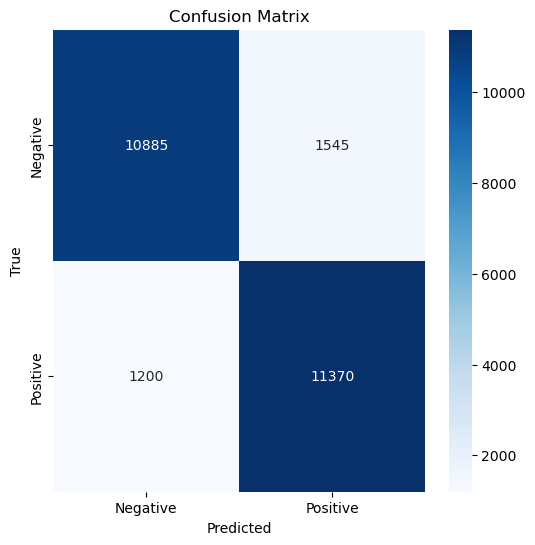

Predicted Sentiment: Negative


In [11]:
# TASK 5: Model Evaluation 

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Test with a new review
# 4. Tester le modèle avec un nouvel avis
new_review = "The movie had great visuals, but the storyline was dull and predictable."
# Prétraitement du texte
new_review_processed = tfidf.transform([new_review])  # Transformation du texte en vecteurs avec TF-IDF

# Prédiction avec le modèle
prediction = pipeline.predict(new_review_processed)

# Affichage du résultat
if prediction == 1:
    print("Predicted Sentiment: Positive")
else:
    print("Predicted Sentiment: Negative")


6. Hyperparameter Tuning:

    Goal: Optimize your Logistic Regression model by tuning its hyperparameters.
   
    Task: Use an optimization method to find the best parameters for your model and improve its accuracy.

In [13]:
# TASK 6: Hyperparameter Tuning 
# Step 3: Define the parameter grid to search
param_grid = {
    'clf__C': [0.1, 1, 10, 100],  # Regularization strength
    'clf__penalty': ['l1', 'l2'],  # L1 or L2 regularization
    'clf__solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2 regularization
    'clf__max_iter': [100, 200, 300]  # Maximum number of iterations
}
tracker = EmissionsTracker()
tracker.start()

# Step 4: Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Step 5: Fit the model and find the best parameters
grid_search.fit(X_train, y_train)
# Stop tracking and log emissions
emissions = tracker.stop()

# Step 6: Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
# Step 7: Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.3f}")
# TASK 8: Track emissions during Hyperparameter Tuning
print(f"Estimated CO₂ emissions: {emissions:.6f} kg")

[codecarbon INFO @ 08:50:13] [setup] RAM Tracking...
[codecarbon INFO @ 08:50:13] [setup] CPU Tracking...
[codecarbon WARNING @ 08:50:13] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 08:50:15] We saw that you have a 12th Gen Intel(R) Core(TM) i7-1255U but we don't know it. Please contact us.
[codecarbon INFO @ 08:50:15] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-1255U
[codecarbon INFO @ 08:50:15] [setup] GPU Tracking...
[codecarbon INFO @ 08:50:15] No GPU found.
[codecarbon INFO @ 08:50:15] >>> Tracker's metadata:
[codecarbon INFO @ 08:50:15]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 08:50:15]   Python version: 3.12.7
[codecarbon INFO @ 08:50:15]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 08:50:15]   Available RAM : 15.679 GB
[codecarbon INFO @ 08:50:15]   CPU count: 12
[codecarbon INFO @ 08:50:15]   CPU model: 12th Gen In

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[codecarbon INFO @ 08:50:33] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.879655361175537 W
[codecarbon INFO @ 08:50:33] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:33] 0.000202 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:50:48] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.879655361175537 W
[codecarbon INFO @ 08:50:48] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:48] 0.000404 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:51:03] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.879655361175537 W
[codecarbon INFO @ 08:51:03] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:03] 0.000605 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:51:18] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.879655361175537 W
[codecarbon INFO @ 08:51:18] Energy consumed for a

Best parameters found:  {'clf__C': 1, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Test Accuracy: 0.891
Estimated CO₂ emissions: 0.000029 kg


7. Learning Curve Analysis:

    Goal: Diagnose your model's performance by plotting learning curves.
   
    Task: Analyze training and validation performance as a function of the training set size to identify underfitting or overfitting issues.


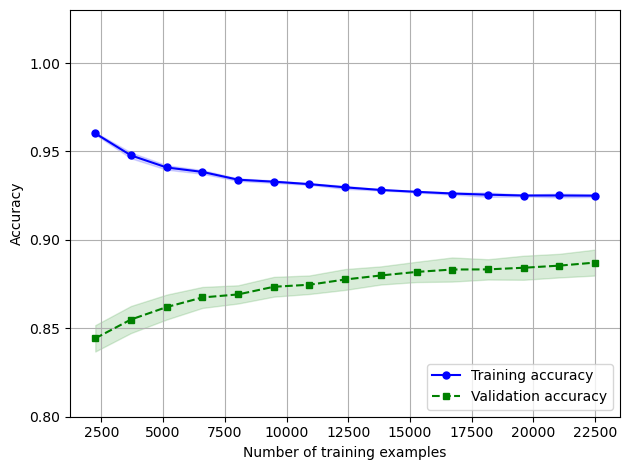

In [15]:
# TASK 7: Learning Curve Analysis
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipeline,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 15),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()


9. Ethical Considerations and Explainability:

    Goal: Discuss the ethics in using and deploying your AI-based solution by investigating and implementing suitable explainability methods.
    
    Task: Understanding how a machine learning model makes predictions is crucial for ensuring transparency, fairness, and accountability in AI deployment. One of the widely used techniques for model explainability is SHAP (SHapley Additive exPlanations), which helps determine how much each feature (word) contributes to a prediction.
    In this task, you will use SHAP to analyze the impact of individual words on sentiment classification. This will allow you to visualize which words increase or decrease the probability of a positive or negative sentiment prediction. Additionally, discuss key aspects such as potential biases in the model, fairness in outcomes, and accountability in AI decision-making. You can find more information here: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html

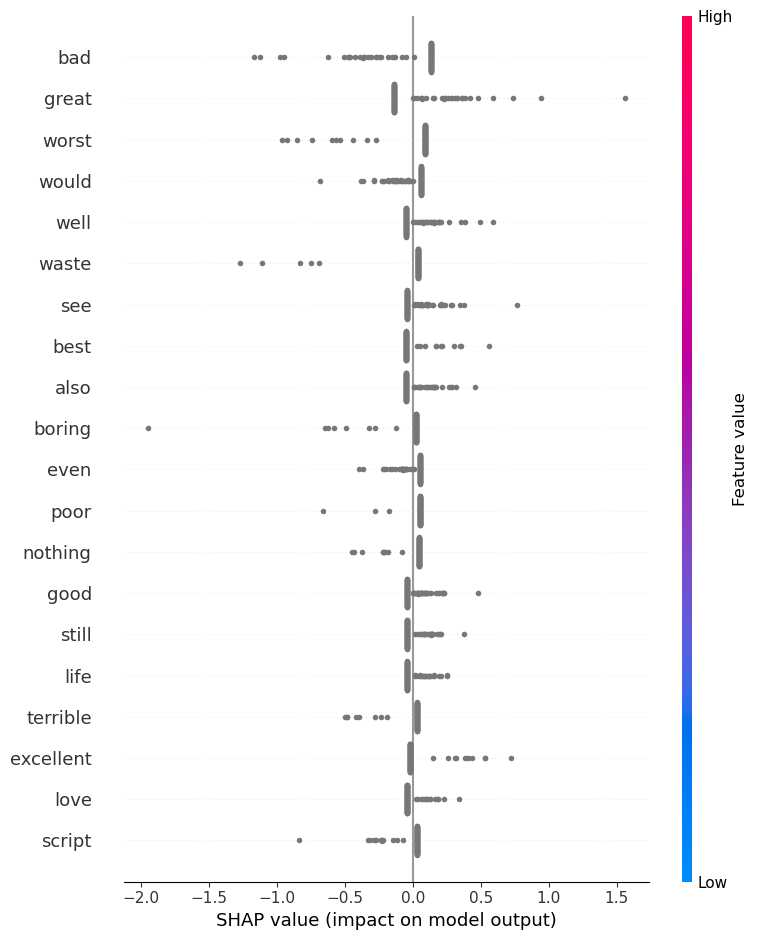

In [21]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Étape 1 : Initialisation de l'explainer SHAP
explainer = shap.Explainer(pipeline.named_steps['clf'], X_train)

# 🔹 Étape 2 : Calcul des valeurs SHAP pour un sous-ensemble de X_test
shap_values = explainer(X_test[:100])  # Prendre 100 exemples pour éviter un calcul trop long

# 🔹 Étape 3 : Affichage du résumé global des contributions des mots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test[:100], feature_names=tfidf.get_feature_names_out())

In [141]:
# TASK 9: Ethical Considerations & Explainability

# Show SHAP summary plot with proper feature names
# Initialize SHAP explainer
import shap
import numpy as np
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Texte d'exemple
texts = ["This is so good", "I love this", "This is bad", "I hate this"]

# Créer le TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer la transformation sur les textes
X = vectorizer.fit_transform(texts)

# Extraire les caractéristiques
features = vectorizer.transform(["   boring awful"]).toarray()

# Afficher les caractéristiques
print("Features for 'This is so good':", features[0])


Features for 'This is so good': [0. 0. 0. 0. 0. 0. 0.]


10. Deployment Considerations for Embedded Systems:

    Goal: Optimize and convert the trained logistic regression model for deployment on embedded systems like Arduino
    
    Task: To deploy the trained logistic regression model on a resource-constrained embedded system like an Arduino, we must optimize and convert the model into a format suitable for execution in an environment with limited memory and processing power. Since embedded systems do not support direct execution of machine learning models trained in Python, we extract the model’s learned parameters—namely, the weights and bias—after training. These parameters are then quantized to fixed-point integers to eliminate the need for floating-point calculations, which are inefficient on microcontrollers.
    Once quantization is applied, we generate a C++ .h header file containing the model’s coefficients and bias, formatted in a way that allows direct use within an Arduino sketch. The final model is optimized to perform inference using integer arithmetic, making it both lightweight and efficient for deployment on microcontrollers. You can find more information here: https://medium.com/@thommaskevin/tinyml-binomial-logistic-regression-0fdbf00e6765

In [129]:
# TASK 10: Deployment Considerations (Model Quantization & Export for Arduino)
# Extract weights and bias from the trained logistic regression model
from sklearn.decomposition import PCA
# Extrait les coefficients et le biais du modèle entraîné
# Accéder au modèle de régression logistique
# Assuming best_model is your trained logistic regression model

# Accéder aux coefficients et à l'intercept
# Récupérer le modèle de régression logistique depuis le pipeline
# Étape 2 : Appliquer PCA pour réduire la taille du modèle
pca = PCA(n_components=10)  # Réduction à 10 dimensions

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Étape 3 : Réentraîner le modèle sur les données réduites

pipeline.fit(X_train_pca, y_train)
log_reg_model = pipeline.named_steps['clf']
# Étape 4 : Extraction des coefficients et biais après PCA
coefficients = log_reg_model.coef_[0]
intercept = log_reg_model.intercept_[0]

print("Coefficients après PCA:", coefficients)
print("Intercept après PCA:", intercept)

# Étape 5 : Quantification pour réduire l'usage de float sur Arduino
def quantize(coefficients, scale_factor=1000):
    return np.round(coefficients * scale_factor).astype(int)

quantized_coefficients = quantize(coefficients)
quantized_intercept = np.round(intercept * 1000).astype(int)

print("Quantized Coefficients:", quantized_coefficients)
print("Quantized Intercept:", quantized_intercept)

# Étape 6 : Génération du code C++ pour Arduino
def generate_cpp_code(intercept, coefficients, threshold=0.5):
    cpp_code = "#ifndef LOGISTIC_REGRESSOR_H\n#define LOGISTIC_REGRESSOR_H\n\n"
    cpp_code += "#include <math.h>\n\n"
    
    cpp_code += "namespace Eloquent {\nnamespace ML {\nnamespace Port {\n"
    cpp_code += "class LogisticRegressor {\npublic:\n\n"

    cpp_code += "int predict(int *x) {\n"
    cpp_code += f"    int coefficients[{len(coefficients)}] = " + "{ " + ", ".join(map(str, coefficients)) + " };\n"
    cpp_code += f"    int z = {intercept};\n"

    cpp_code += f"    for (int i = 0; i < {len(coefficients)}; i++) {{\n"
    cpp_code += "        z += coefficients[i] * x[i];\n"
    cpp_code += "    }\n\n"

    cpp_code += "    float probability = 1 / (1 + exp(-1.0 * z / 1000.0));\n"
    cpp_code += f"    return (probability >= {threshold}) ? 1 : 0;\n"
    cpp_code += "}\n};\n\n}}}\n#endif"

    return cpp_code

# Générer et sauvegarder le fichier pour Arduino
cpp_code = generate_cpp_code(quantized_intercept, quantized_coefficients)
with open('./LogisticRegressor.h', 'w') as file:
    file.write(cpp_code)

print("✅ Modèle exporté avec succès pour Arduino avec PCA !")


Coefficients après PCA: [ -9.33412922  -7.59906613 -10.73831699 -29.23872238   4.58182866
   0.40536354 -10.62814349  11.83237404  -1.23071263   0.90370032]
Intercept après PCA: -0.15837057409179883
Quantized Coefficients: [ -9334  -7599 -10738 -29239   4582    405 -10628  11832  -1231    904]
Quantized Intercept: -158
✅ Modèle exporté avec succès pour Arduino avec PCA !
